In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import matplotlib.pyplot as plt

In [92]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [93]:
class_names = ['glioma', 'menin', 'tumor']

In [94]:
image_data = np.load('image_data.npy')
image_labels = np.load('image_labels.npy')

# update shape to match PyTorch's format (Examples, Channels, Height, Width)
updated_image_data_temp = np.swapaxes(image_data, 1, 3)
updated_image_data = np.swapaxes(updated_image_data_temp, 2, 3)

print('Orginal shape: ', image_data.shape)
print('New shape: ', updated_image_data.shape)

Orginal shape:  (6056, 256, 256, 3)
New shape:  (6056, 3, 256, 256)


In [95]:
model_one = nn.Sequential(
    # input layer
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
    nn.ReLU(),

    # first conv layer
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5), # 32 --> 32 channels (input layer)
    nn.ReLU(),
    nn.BatchNorm2d(32), # noramalization
    nn.MaxPool2d((2, 2)), # pooling into 2x2
    nn.Dropout2d(0.1), # remove 10% for regularization

    # second conv layer
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # 32 --> 64
    nn.ReLU(), # activation
    nn.BatchNorm2d(64), # noramalization
    nn.MaxPool2d((2, 2)), # pooling into 2x2 frames
    nn.Dropout2d(0.1), # remove 10% for regularization

    nn.AdaptiveAvgPool2d((4, 4)), # Avg pooling into 4x4 to reduce size
    
    nn.Flatten(), # force to 1D
    nn.Linear(64*16, 128), # fully connected layer
    nn.ReLU(), # activation
    nn.Dropout(0.3), # remove 30% for regularization

    nn.Linear(128, len(class_names)) # Prediction Layer
)

model_two = nn.Sequential(
    # input layer
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
    nn.ReLU(),

    # first conv layer
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # 16 --> 32 channels (input layer)
    nn.ReLU(),
    nn.BatchNorm2d(32), # noramalization
    nn.MaxPool2d((2, 2)), # pooling into 2x2
    nn.Dropout2d(0.1), # remove 10% for regularization

    # second conv layer
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # 32 --> 64
    nn.ReLU(), # activation
    nn.BatchNorm2d(64), # noramalization
    nn.MaxPool2d((2, 2)), # pooling into 2x2 frames
    nn.Dropout2d(0.2), # remove 20% for regularization

    nn.AdaptiveAvgPool2d((4, 4)), # Avg pooling into 4x4 to reduce size
    
    nn.Flatten(), # force to 1D
    nn.Linear(64*16, 64), # fully connected layer
    nn.ReLU(), # activation
    nn.Dropout(0.4), # remove 40% for regularization


    nn.Linear(64, len(class_names)) # Prediction Layer
)

# set to GPU for acceleration
mps_device = torch.device("mps")
model_one.to(mps_device)
model_two.to(mps_device)


Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Dropout2d(p=0.1, inplace=False)
  (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (8): ReLU()
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): Dropout2d(p=0.2, inplace=False)
  (12): AdaptiveAvgPool2d(output_size=(4, 4))
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=64, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.4, inplace=False)
  (17): Linear(in_features=64, out_features=3, bias=True)
)

In [96]:
# class for custom dataset needed for pytorch 
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# create train test splits
x_train_one, x_test_one, y_train_one, y_test_one = train_test_split(updated_image_data, image_labels, test_size=0.2, random_state=13, shuffle=True)
x_train_two, x_test_two, y_train_two, y_test_two= train_test_split(updated_image_data, image_labels, test_size=0.2, random_state=10, shuffle=True)

# ecode labels numerically
label_encoder = LabelEncoder() 
y_train_one = label_encoder.fit_transform(y_train_one)
y_test_one = label_encoder.transform(y_test_one)

y_train_two = label_encoder.fit_transform(y_train_two)
y_test_two = label_encoder.transform(y_test_two)

# create custom dataset objects for train and test sets
train_set_one = CustomDataset(x_train_one, y_train_one)
test_set_one = CustomDataset(x_test_one, y_test_one)

train_set_two = CustomDataset(x_train_two, y_train_two)
test_set_two = CustomDataset(x_test_two, y_test_two)


In [97]:
# create loaders for batches
training_loader_one = DataLoader(train_set_one, batch_size=10, shuffle=True)
validation_loader_one = DataLoader(test_set_one, batch_size=10, shuffle=False)

training_loader_two = DataLoader(train_set_two, batch_size=10, shuffle=True)
validation_loader_two = DataLoader(test_set_two, batch_size=10, shuffle=False)

# set loss and opimizer functions
loss_fn = nn.CrossEntropyLoss()
optimizer_one = torch.optim.Adam(model_one.parameters(), lr = 0.001)
optimizer_two = torch.optim.Adam(model_two.parameters(), lr = 0.0005)


In [98]:
# code for training on single epoch MODEL1
def train_single_epoch_one(epoch_index, tb_writer):
    running_loss_one = 0.0
    total_loss_one = 0.0  # Track total for the entire epoch
    
    for i, data in enumerate(training_loader_one):
        inputs, labels = data
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        
        # Zero gradients
        optimizer_one.zero_grad()

        # Make predictions
        outputs = model_one(inputs)

        # Compute loss and gradients
        loss_one = loss_fn(outputs, labels)
        loss_one.backward()

        # Adjust learning weights
        optimizer_one.step()

        # Accumulate losses
        batch_loss = loss_one.item()
        running_loss_one += batch_loss
        total_loss_one += batch_loss * inputs.size(0)  # Scale by batch size
        
        # Report every 1000 batches
        if i % 1000 == 999:
            avg_loss_one = running_loss_one / 1000
            print('  batch {} loss: {:.4f}'.format(i + 1, avg_loss_one))
            tb_x = epoch_index * len(training_loader_one) + i + 1
            tb_writer.add_scalar('Loss/train', avg_loss_one, tb_x)
            running_loss_one = 0.0  # ← RESET after reporting!
    
    # Return average loss for entire epoch
    epoch_loss_one = total_loss_one / len(training_loader_one.dataset)
    return epoch_loss_one

# code for training on single epoch MODEL2
def train_single_epoch_two(epoch_index, tb_writer):
    running_loss_two = 0.0
    total_loss_two = 0.0  # Track total for the entire epoch
    
    for i, data in enumerate(training_loader_two):
        inputs, labels = data
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        
        # Zero gradients
        optimizer_two.zero_grad()

        # Make predictions
        outputs = model_two(inputs)

        # Compute loss and gradients
        loss_two = loss_fn(outputs, labels)
        loss_two.backward()

        # Adjust learning weights
        optimizer_two.step()

        # Accumulate losses
        batch_loss = loss_two.item()
        running_loss_two += batch_loss
        total_loss_two += batch_loss * inputs.size(0)  # Scale by batch size
        
        # Report every 1000 batches
        if i % 1000 == 999:
            avg_loss_two = running_loss_two / 1000
            print('  batch {} loss: {:.4f}'.format(i + 1, avg_loss_two))
            tb_x = epoch_index * len(training_loader_two) + i + 1
            tb_writer.add_scalar('Loss/train', avg_loss_two, tb_x)
            running_loss_two = 0.0  # ← RESET after reporting!
    
    # Return average loss for entire epoch
    epoch_loss_two = total_loss_two / len(training_loader_two.dataset)
    return epoch_loss_two

In [ ]:
# TRAINING LOOP!
epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer_one = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
writer_two = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

EPOCHS = 30
best_vloss_one = 1_000_000.
best_vloss_two = 1_000_000.

true_labels_list_one = []
predicted_labels_list_one = []
train_loss_list_one = []
val_loss_list_one = []
val_accuracy_two = []


true_labels_list_two = []
predicted_labels_list_two = []
train_loss_list_two = []
val_loss_list_two = []
val_accuracy_one = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number +1))

    model_one.train(True)
    model_two.train(True)

    avg_loss_one = train_single_epoch_one(epoch_number, writer_one)
    avg_loss_two = train_single_epoch_two(epoch_number, writer_two)

    running_vloss_one = 0.0
    running_vloss_two = 0.0

    model_one.eval()
    model_two.eval()

    with torch.no_grad():
        # val one
        for i, vdata in enumerate(validation_loader_one):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(mps_device)
            vlabels = vlabels.to(mps_device)
            voutputs = model_one(vinputs)
            _, predicted = torch.max(voutputs, 1)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss_one += vloss

            true_labels_list_one.extend(vlabels.cpu().numpy())
            predicted_labels_list_one.extend(predicted.cpu().numpy())


        #val two
        for i, vdata in enumerate(validation_loader_two):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(mps_device)
            vlabels = vlabels.to(mps_device)
            voutputs = model_two(vinputs)
            _, predicted = torch.max(voutputs, 1)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss_two += vloss

            true_labels_list_two.extend(vlabels.cpu().numpy())
            predicted_labels_list_two.extend(predicted.cpu().numpy())

    val_accuracy_one.append(metrics.accuracy_score(true_labels_list_one, predicted_labels_list_one))            
    val_accuracy_two.append(metrics.accuracy_score(true_labels_list_two, predicted_labels_list_two))
    
    avg_vloss_one = running_vloss_one / (i + 1)
    avg_vloss_two = running_vloss_two / (i + 1)

    print('Model 1 Loss train {} valid {}'.format(avg_loss_one, avg_vloss_one))
    print('Model 2 Loss train {} valid {}'.format(avg_loss_two, avg_vloss_two))

    val_loss_list_one.append(avg_vloss_one)
    val_loss_list_two.append(avg_vloss_two)

    train_loss_list_one.append(avg_loss_one)
    train_loss_list_two.append(avg_loss_two)

    writer_one.add_scalars('Training vs. Validation Loss',
                       {'Training' : avg_loss_one, 'Validation' : avg_vloss_one},
                       epoch_number + 1)
    
    writer_two.add_scalars('Training vs. Validation Loss',
                       {'Training' : avg_loss_two, 'Validation' : avg_vloss_two},
                       epoch_number + 1)
    
    writer_one.flush()
    writer_two.flush()

    if avg_vloss_one < best_vloss_one:
        best_vloss_one = avg_vloss_one
        model_path = 'model_one_{}_{}'.format(timestamp, epoch_number)
        torch.save(model_one.state_dict(), model_path)

    if avg_vloss_two < best_vloss_two:
        best_vloss_two = avg_vloss_two
        model_path = 'model_two_{}_{}'.format(timestamp, epoch_number)
        torch.save(model_two.state_dict(), model_path)
    
    epoch_number += 1


EPOCH 1:
Model 1 Loss train 0.6487700572432712 valid 0.4884112477302551
Model 2 Loss train 0.6500231714213219 valid 0.5256965756416321
EPOCH 2:
Model 1 Loss train 0.5564296985803361 valid 0.41676250100135803
Model 2 Loss train 0.5464920085830988 valid 0.5520007610321045
EPOCH 3:
Model 1 Loss train 0.5124802196646012 valid 0.5297783613204956
Model 2 Loss train 0.4653133925244298 valid 1.10809326171875
EPOCH 4:
Model 1 Loss train 0.46215447565597584 valid 0.5175377130508423
Model 2 Loss train 0.44959035896004773 valid 0.38002824783325195
EPOCH 5:
Model 1 Loss train 0.44392657111699574 valid 0.3883915841579437
Model 2 Loss train 0.3744020588806746 valid 0.3635452389717102
EPOCH 6:
Model 1 Loss train 0.4018163735856026 valid 0.39638394117355347
Model 2 Loss train 0.33621914846427325 valid 0.30508214235305786
EPOCH 7:
Model 1 Loss train 0.37154716341260247 valid 0.3242761194705963
Model 2 Loss train 0.2921417867918641 valid 0.4332138001918793
EPOCH 8:


KeyboardInterrupt: 

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83      2835
         1.0       0.79      0.75      0.77      2835
         2.0       0.84      0.89      0.86      2814

    accuracy                           0.82      8484
   macro avg       0.82      0.82      0.82      8484
weighted avg       0.82      0.82      0.82      8484

              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85      2982
         1.0       0.78      0.65      0.71      2835
         2.0       0.82      0.85      0.83      2667

    accuracy                           0.80      8484
   macro avg       0.80      0.80      0.80      8484
weighted avg       0.80      0.80      0.80      8484



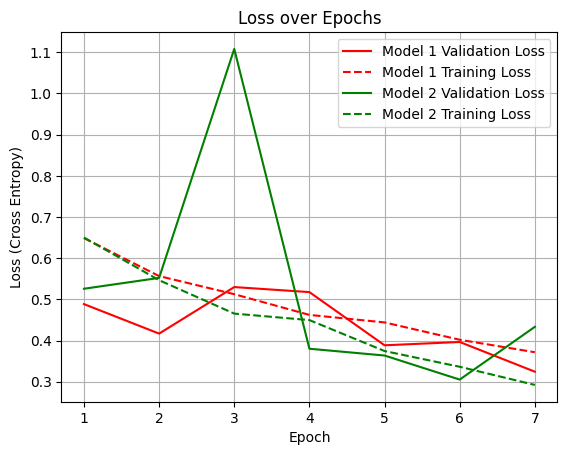

[0.8, 0.85, 0.9, 0.875, 0.88, 0.8833333333333333, 0.8857142857142857, 0.8875, 0.8777777777777778, 0.88, 0.8818181818181818, 0.875, 0.8692307692307693, 0.8642857142857143, 0.86, 0.85625, 0.8470588235294118, 0.8444444444444444, 0.8421052631578947, 0.84, 0.8333333333333334, 0.8409090909090909, 0.8434782608695652, 0.8416666666666667, 0.84, 0.8461538461538461, 0.8481481481481481, 0.8535714285714285, 0.8551724137931035, 0.85, 0.8451612903225807, 0.840625, 0.8363636363636363, 0.8382352941176471, 0.8342857142857143, 0.825, 0.8216216216216217, 0.8157894736842105, 0.8102564102564103, 0.81, 0.8121951219512196, 0.8119047619047619, 0.813953488372093, 0.8136363636363636, 0.8133333333333334, 0.8108695652173913, 0.8148936170212766, 0.8145833333333333, 0.8122448979591836, 0.812, 0.8117647058823529, 0.8096153846153846, 0.809433962264151, 0.8055555555555556, 0.8054545454545454, 0.8017857142857143, 0.8, 0.7965517241379311, 0.7966101694915254, 0.8, 0.8, 0.8, 0.8015873015873016, 0.803125, 0.8015384615384615

ValueError: x and y must have same first dimension, but have shapes (7,) and (854,)

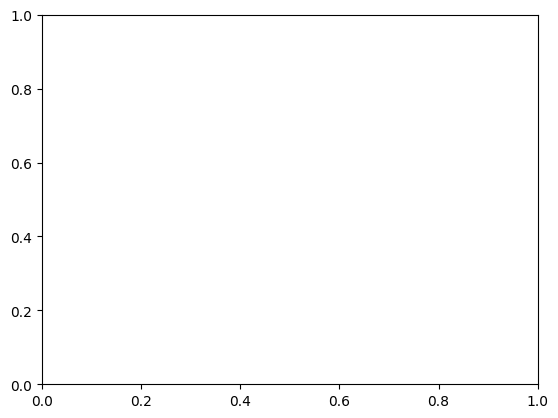

In [103]:
class_report_one = metrics.classification_report(true_labels_list_one, predicted_labels_list_one)
print(class_report_one)

class_report_two = metrics.classification_report(true_labels_list_two, predicted_labels_list_two)
print(class_report_two)

val_losses_one = []
for loss in val_loss_list_one:
    val_losses_one.append(loss.cpu())

val_losses_two = []
for loss in val_loss_list_two:
    val_losses_two.append(loss.cpu())

epoch__count_array = (np.arange(epoch_number) + 1)

plt.figure(1, clear=True)

plt.plot(epoch__count_array, val_losses_one, color='red', label='Model 1 Validation Loss')
plt.plot(epoch__count_array, train_loss_list_one, color='red', linestyle='--', label='Model 1 Training Loss')

plt.plot(epoch__count_array, val_losses_two, color='green', label='Model 2 Validation Loss')
plt.plot(epoch__count_array, train_loss_list_two, linestyle='--', color='green', label='Model 2 Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()

plt.figure(2, clear=True)
print(val_accuracy_one)
plt.plot(epoch__count_array, val_accuracy_one, label='Model 1')
plt.plot(epoch__count_array, val_accuracy_two, label='Model 2')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (TP / (TP + FP))')
plt.legend()
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.show()